In [3]:
import numpy as np
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from math import pi, acos, sqrt, sin
from qiskit.tools.visualization import circuit_drawer
from qiskit.aqua.components.iqfts import Standard
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.utils import CircuitFactory
from qiskit.aqua.circuits import PhaseEstimationCircuit
import time

%matplotlib inline

In [4]:
def sprinkler(qc,q,a):
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])
    qc.ccx(q[0],q[1],a[0])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(a[0],a[1],a[3])
    qc.ccx(a[2],a[3],a[4])
    qc.ccx(a[4],q[3],a[5]) #a[5] output
    qc.ccx(a[2],a[3],a[4])
    qc.ccx(a[0],a[1],a[3])
    qc.ccx(q[0],q[2],a[2])
    qc.ccx(q[1],q[2],a[1])
    qc.ccx(q[0],q[1],a[0])
    qc.x(q[2])
    qc.x(a[0])
    qc.x(a[1])
    qc.x(a[2])


In [5]:
class cf(CircuitFactory):
    def build(self, qc, q, a):

        # Put the target into the |-⟩ state
        qc.x(a[5])
        qc.h(a[5])
        # since the target is in the |-⟩ state,
        # flipping the target if the register satisfies the oracle condition will apply a -1 factor to the state
        sprinkler(qc,q,a) 
        qc.h(a[5])
        qc.x(a[5])
        
        # Grover iteration
        for i in range(q.size):
            qc.h(q[i])
            
        # |0> -> |0>,  |x> -> -|x>
        # flipping all bits
        for i in range(q.size):
            qc.x(q[i])
        # applying Z to a qubit of the register if all bits are 1: this implements |0> -> -|0>,  |x> -> |x>
        qc.ccx(q[0],q[1],a[0]) 
        qc.ccx(a[0],q[2],a[1])
        qc.ccx(a[1],q[3],a[2])
        qc.cz(a[2],q[0])
        # adding a global phase of -1 so that |0> -> |0>,  |x> -> -|x>
        qc.ry(2*pi,q[0]) 
        for i in range(q.size):
            qc.x(q[i])
        for i in range(q.size):
            qc.h(q[i])

class ini(CircuitFactory):
    def build(self, qc, q, a):
        theta0=2.0*acos(sqrt(0.3));
        theta1=2.0*acos(sqrt(0.2));
        theta2=2.0*acos(sqrt(0.5));
        qc.ry(theta0,q[0]);
        qc.ry(theta1,q[1]);
        qc.ry(theta2,q[2]);
        qc.h(q[3])

cfs=cf(4)
inis=ini(4)

In [6]:
iqftr=Standard(5)
c=PhaseEstimationCircuit(unitary_circuit_factory=cfs,state_in_circuit_factory=inis,num_ancillae=5,
    iqft=iqftr,num_time_slices=5)
q=QuantumRegister(4)
a=QuantumRegister(6)
aa=QuantumRegister(5)
cc=c.construct_circuit(state_register=q,auxiliary_register=a,ancillary_register=aa,measurement=True)

In [7]:
from qiskit import IBMQ
IBMQ.save_account('b5c20041f9deffa38c951ea7137c2d6feed910e2b3b151a12e1ab8e0e44fc75ec71067ecd1af97def6401368b57684b70f080916ce0516f9883496c0bbc55e7e')

In [8]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_16_melbourne')
print(backend, backend.status().pending_jobs)
start = time.time()

job_sim = execute(cc, backend, shots=10)
end = time.time()
print(end - start)

result_sim = job_sim.result()

ibmq_16_melbourne 15
301.8477749824524


IBMQJobFailureError: 'Unable to retrieve job result. Job has failed. Use job.error_message() to get more details.'

In [9]:
job_sim.error_message()

'Circuit runtime is greater than the device repetition rate. Error code: 8020.'

In [8]:
counts  = result_sim.get_counts(cc)
weights={}
for  key, value in counts.items():
    phi=pi*int(key)/2**5 
    newkey=2.0*sin(phi)**2
    weights[newkey]=value
weights

{'1111': 1, '1100': 4, '0100': 3, '1101': 1, '1011': 1}

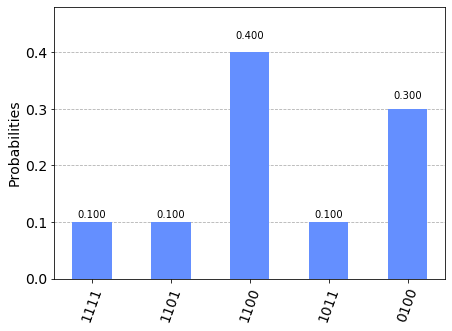

In [9]:
plot_histogram(weights,sort='desc',figsize=(15,3))